# White noise fitting example (EFAC and EQUAD)

This notebook corresponds to Section 6.1 of Susobhanan+ 2024.

In [1]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise.signals.parameter import Uniform, LinearExp
from enterprise.signals.selections import Selection, no_selection

from pint.models import get_model_and_toas
from pint.fitter import Fitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion
from pint.output.publish import publish

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
from matplotlib import pyplot as plt
from copy import deepcopy

Optional mpi4py package is not installed.  MPI support is not available.
Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [2]:
# Suppress annoying messages.
setup_log(level="WARNING")

1

In [3]:
m, t = get_model_and_toas("sim1.par", "sim1.tim", planets=True)

In [4]:
print(m)

# Created: 2024-04-23T12:49:36.735146
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
TZRMJD     

## Model comparison using AIC

What components are required? EFAC or EQUAD or both or neither?

In [5]:
result = np.zeros((2,2))
for eff in [True, False]:
    for eqf in [True, False]:
        m1 = deepcopy(m)
        m1.EFAC1.value = 1
        m1.EQUAD1.value = 1e-4
        m1.EFAC1.frozen = not eff
        m1.EQUAD1.frozen = not eqf

        ftr = Fitter.auto(t, m1)
        ftr.fit_toas(noise_fit_niter=5)

        fp = set(m1.free_params).intersection(["EFAC1", "EQUAD1"])
        
        result[int(not eff), int(not eqf)] = akaike_information_criterion(ftr.model, t)

print(np.round(result - np.min(result)))

[[   0.  198.]
 [  44. 5191.]]


AIC seems to favour EFAC + EQUAD.

## Fitting for EFAC and EQUAD using PINT

In [6]:
# Let us fit for both EFAC & EQUAD.
# The original model has both of them already. 
# So we can use it as it is.
ftr = Fitter.auto(t, m)
ftr.fit_toas()

In [7]:
# Look at the post-fit model.
# Both EFAC and EQUAD have been estimated, along with their uncertainties.
print(ftr.model)

# Created: 2024-04-23T12:50:07.692103
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567183797
FINISH             56985.0000000464162847
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2000.0000000022656
CHI2R                  1.0045203415380541
TRES                2.4134591611789330881
RAJ                      4:59:59.99999598 1 0.00000275770694145185
DECJ                    15:00:00.00027474 1 0.00023540336077444333
PMRA                                  0.0
PMDEC                  

## Bayesian parameter estimation using ENTERPRISE & PTMCMCSampler

In [8]:
psr = Pulsar(ftr.model, t)

In [9]:
tm = TimingModel()
wn = MeasurementNoise(efac=Uniform(0.5, 2.0), log10_t2equad=LinearExp(-8, -4))

In [10]:
model = tm + wn

In [11]:
pta = PTA([model(psr)])

In [12]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim1/"
Niter = 100000

In [13]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [14]:
sampler.sample(
    x0,
    Niter,
)

WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


Finished 10.00 percent in 7.473704 s Acceptance rate = 0.09683Adding DE jump with weight 20
Finished 99.00 percent in 61.889279 s Acceptance rate = 0.245028
Run Complete


In [15]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

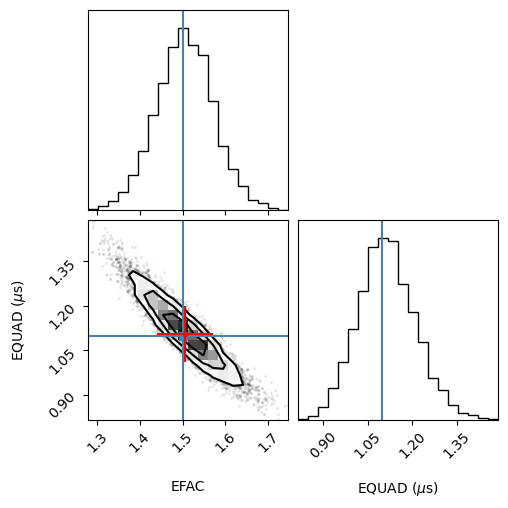

In [16]:
fig = corner.corner(
    burned_chain, 
    labels=["EFAC", "EQUAD ($\\mu$s)"], 
    truths=[m.EFAC1.value, m.EQUAD1.quantity.value],
)

plt.subplot(223)
plt.errorbar(
    [ftr.model.EFAC1.value], 
    [ftr.model.EQUAD1.value],
    xerr=[ftr.model.EFAC1.uncertainty_value], 
    yerr=[ftr.model.EQUAD1.uncertainty_value],
    color="red",
    marker="."
)

plt.savefig("sim1.pdf")

The ENTERPRISE and PINT estimates match really well!

New let's look at the post-fit residuals. It looks like white noise, as it should.

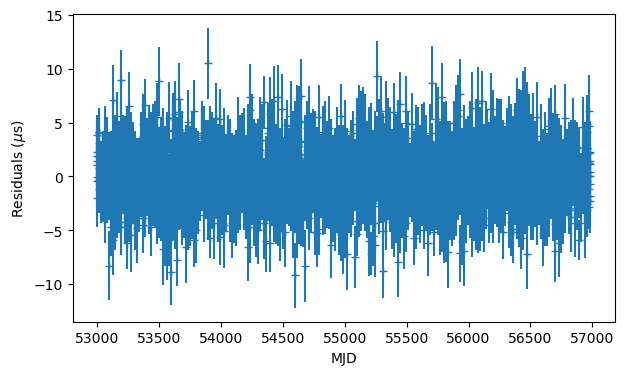

In [17]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)")
plt.xlabel("MJD")
plt.savefig("sim1-resids.pdf")